# 3.7.2 梯度爆炸

In [1]:
import warnings
warnings.simplefilter("ignore")

导入功能模块

In [2]:
import sys

load_dataset_module_path = '../../'
sys.path.append(load_dataset_module_path)

from load_hyperspectral_dataset import (load_hyperspectral_data, y_labels,
                                        extract_features,
                                        plot_selected_categories,
                                        plot_decision_function)

In [3]:
#%matplotlib inline
#%matplotlib notebook 

#%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.utils import shuffle
import seaborn as sns
from ipywidgets import interact_manual


mpl.style.use('ggplot')

加载数据集

In [4]:
img_file_path = '../../Hyperspectral_Project/dc.tif'
label_file_path = '../../Hyperspectral_Project/dctest.project'

raw_X, raw_y, pixel_position = load_hyperspectral_data(img_file_path,
                                                       label_file_path)

hyperspectral_df =  extract_features(raw_X, raw_y)

画出指定类别，训练模型分类

In [5]:
import torch
import numpy as np
import collections
from torch import nn

In [6]:
from torch.utils.data import TensorDataset,DataLoader

In [7]:
inps = torch.tensor(hyperspectral_df[['NDVI', 'MNDWI', 'NDBI']].to_numpy(),
                    dtype=torch.float32)
tgts = torch.tensor(raw_y)
                    #, dtype=torch.float32)
#.view(8079, 1)

index_feature_dataset = TensorDataset(inps, tgts)
index_feature_loader = DataLoader(index_feature_dataset,batch_size=8079)

In [12]:
import matplotlib.ticker as ticker

In [52]:
def exploding_gradient_relu(n_layers,loader, n_epoch=100):

    model_layers = collections.OrderedDict()

    for i in range(n_layers):
        if i == 0:
            model_layers[f'linear_{i+1}'] = torch.nn.Linear(3, 30)
            model_layers[f'relu_{i+1}'] = torch.nn.ReLU()
        else:
            model_layers[f'linear_{i+1}'] = torch.nn.Linear(30, 30)
            model_layers[f'relu_{i+1}'] = torch.nn.ReLU()

    model_layers[f'output_layer'] = torch.nn.Linear(30, 7)

    model = torch.nn.Sequential(model_layers)

    loss_fn = nn.CrossEntropyLoss()

    learning_rate = 1e-6
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    grad_list = [[0.0 for i in range(n_layers)]]
    #n_epoch = 50
    for e in range(n_epoch):
        for X, y in loader:
            # Compute prediction and loss
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            grad_list.append([
                np.linalg.norm(model[2 * i].weight.grad.numpy(), ord=2)
                for i in range(n_layers)
            ])
            optimizer.step()

    grad = np.array(grad_list)

    #     plt.bar(range(n_layers),weights_list,label='Absolute value of gradients')
    ax = plt.gca()
    ax.set_yscale('log')

    ax.set_title(f'ReLU with 30 neurons/layer')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    for i in range(grad.shape[1]):

        plt.plot(range(0 , n_epoch + 1),
                 grad[:, i],
                 label=f'Hidden layer {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('$\Vert \delta \Vert$')
    plt.legend(loc='upper left',
           #fontsize=3,
           frameon=False,
           bbox_to_anchor=(1, 1)) 


    plt.savefig(f'ReLU-with-30-neurons-each-layer-input-raw.pdf',
            bbox_inches='tight')

In [22]:
B = raw_X[:, 6:14].mean(axis=1).reshape(-1,1)
G = raw_X[:, 24:37].mean(axis=1).reshape(-1,1)
R = raw_X[:, 45:61].mean(axis=1).reshape(-1,1)

In [23]:
RGB_X = np.hstack((R,G,B))

In [24]:
inps = torch.tensor(RGB_X,
                    dtype=torch.float32)
tgts = torch.tensor(raw_y)
                    #, dtype=torch.float32)
#.view(8079, 1)

RGB_X_dataset = TensorDataset(inps, tgts)
RGB_X_loader = DataLoader(RGB_X_dataset,batch_size=8079)

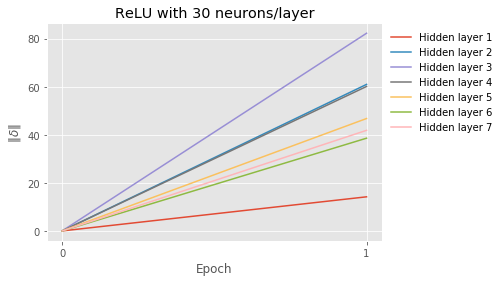

In [17]:
exploding_gradient_relu(n_layers=7,loader=RGB_X_loader,n_epoch=1)    

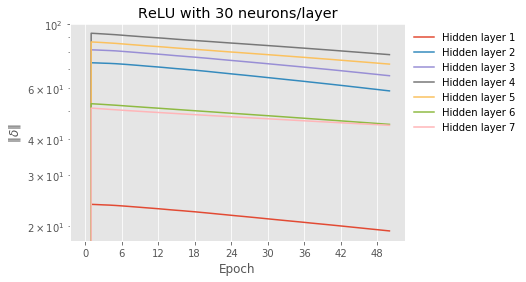

In [53]:
exploding_gradient_relu(n_layers=7,loader=RGB_X_loader,n_epoch=50) 

In [37]:
def exploding_gradient_relu_BN(n_layers,loader, n_epoch=100):

    model_layers = collections.OrderedDict()

    for i in range(n_layers):
        if i == 0:
            model_layers[f'linear_{i+1}'] = torch.nn.Linear(3, 30)
        else:
            model_layers[f'linear_{i+1}'] = torch.nn.Linear(30, 30)
        
        model_layers[f'bn_{i+1}'] = torch.nn.BatchNorm1d(30)       
        model_layers[f'relu_{i+1}'] = torch.nn.ReLU()

    model_layers[f'output_layer'] = torch.nn.Linear(30, 7)

    model = torch.nn.Sequential(model_layers)

    loss_fn = nn.CrossEntropyLoss()

    learning_rate = 0.1
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    grad_list = [[0.0 for i in range(n_layers)]]
    #n_epoch = 50
    for e in range(n_epoch):
        for X, y in loader:
            # Compute prediction and loss
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            grad_list.append([
                np.linalg.norm(model[3 * i].weight.grad.numpy(), ord=2)
                for i in range(n_layers)
            ])
            optimizer.step()

    grad = np.array(grad_list)

    #     plt.bar(range(n_layers),weights_list,label='Absolute value of gradients')
    ax = plt.gca()
    ax.set_yscale('log')

    ax.set_title(f'ReLU+BN with 30 neurons/layer')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    for i in range(grad.shape[1]):

        plt.plot(range(0 , n_epoch + 1),
                 grad[:, i],
                 label=f'Hidden layer {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('$\Vert \delta \Vert$')
    plt.legend(loc='upper left',
           #fontsize=3,
           frameon=False,
           bbox_to_anchor=(1, 1)) 


    plt.savefig(f'ReLU-BN-with-30-neurons-each-layer-input-raw.pdf',
            bbox_inches='tight')

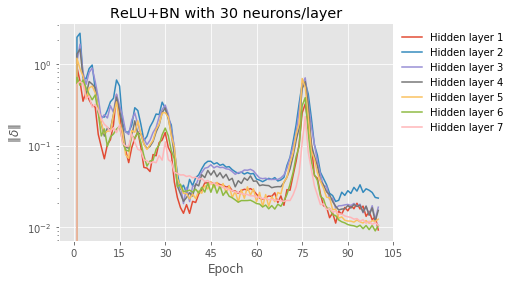

In [45]:
exploding_gradient_relu_BN(n_layers=7,loader=RGB_X_loader,n_epoch=100) 

In [39]:
def exploding_gradient_relu(n_layers,loader, n_epoch=100):

    model_layers = collections.OrderedDict()

    for i in range(n_layers):
        if i == 0:
            model_layers[f'linear_{i+1}'] = torch.nn.Linear(3, 30)
            model_layers[f'relu_{i+1}'] = torch.nn.ReLU()
        else:
            model_layers[f'linear_{i+1}'] = torch.nn.Linear(30, 30)
            model_layers[f'relu_{i+1}'] = torch.nn.ReLU()

    model_layers[f'output_layer'] = torch.nn.Linear(30, 7)

    model = torch.nn.Sequential(model_layers)

    loss_fn = nn.CrossEntropyLoss()

    learning_rate = 0.1
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    grad_list = [[0.0 for i in range(n_layers)]]
    #n_epoch = 50
    for e in range(n_epoch):
        for X, y in loader:
            # Compute prediction and loss
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            grad_list.append([
                np.linalg.norm(model[2 * i].weight.grad.numpy(), ord=2)
                for i in range(n_layers)
            ])
            optimizer.step()

    grad = np.array(grad_list)

    #     plt.bar(range(n_layers),weights_list,label='Absolute value of gradients')
    ax = plt.gca()
    ax.set_yscale('log')

    ax.set_title(f'ReLU with 30 neurons/layer')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    for i in range(grad.shape[1]):

        plt.plot(range(0 , n_epoch + 1),
                 grad[:, i],
                 label=f'Hidden layer {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('$\Vert \delta \Vert$')
    plt.legend(loc='upper left',
           #fontsize=3,
           frameon=False,
           bbox_to_anchor=(1, 1)) 


    plt.savefig(f'ReLU-with-30-neurons-each-layer-input-raw.pdf',
            bbox_inches='tight')

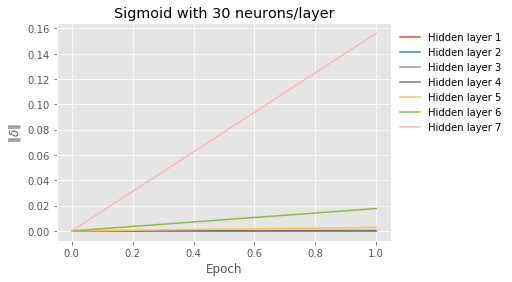

In [40]:
exploding_gradient_sigmoid(n_layers=7,loader=RGB_X_loader,n_epoch=1 )